# Explanation

Most CNN architectures were originally designed for tasks like image classification, where identifying high dimensional features is usually sufficient to accomplish the task effectively. These tasks usually involve taking in images as outputs, and then producing much lower dimensional outputs like image labels.

However, there are a set of (important) tasks that require much more localization, where the network has to understand more low-level features in the images. One such case is the medical image segmentation task, which requires a network to draw border lines around entities in medical images. This task requires the network to understand pixel-level details in order to distinguish between different parts of an image.

In addition to the novelty of this task, the datasets for medical image segmentation are also quite small, making it even more of a challenge.

Despite this, the **U-Net** architecture was able to achieve a new record performance on the ISBI image segmentation challenge.

The U-Net builds on the architecture of CNNs and adds additional inductive biases that are particularly effective for tasks involving **image-to-image** conversion.

Medical segmentation happens to be one such tasks since the output has to be an equivalent sized image to the input image, but with segmentation marks on it.

However, there are many other useful image-to-image tasks which U-Net has become extremely effective for. Notably, diffusion models, which are now the state of the art models for image generation, use U-Nets to convert noisy images into eventual synthesized images.

U-Nets are also particularly useful for high resolution images, where their ability to understand complex details in images is especially valuable.

Models like SDXL and DALL E 2 have U-Nets at the core of their architecture, which is part of why I decided to highlight the U-Net.

### Intuition

The U-Net architecture is an encoder-decoder model. Like most encoder-decoder architectures (more are covered later in this repository in the sequence modeling and image generation sections), the encoder of the model is responsible for encoding some high-dimensional representations, and the decoder is responsible for taking these representations and adding back detail to them.

It has two core pathways to it that account for it's functionality.

The first pathway involves a series of convolutional blocks that "down-sample" and "up-sample" the features.

Each down-sampling block consists of three 3x3 convolutions, each followed by a ReLU activation function, and then a down-sampling max-pool kernel to reduce the total size of the image by a factor of 2. After each convolution, the total channels in the image also grows. The U-Net usually has a number of these down-sampling blocks in sequence.

The up-sampling blocks at the end of the architecture mirror this process in reverse - they first have up-convolutions to map the latents back to less channels but higher dimensions wich each block, with ReLUs in between each convolution. The last layer of the up-sampling section before the output contains 1x1 convolutions for each pixel, allowing the model to output an image of the same dimension as the input.

Between the down-sampling and up-sampling pathways is the "bottleneck" where representations have the most channels and lowest dimensionality.

In order to construct images effectively (in the cast of diffusion models covered in the last section, predict the noise in images correctly), the model needs to learn to store the most useful high-dimensional representations past the bottleneck, and each sequential down-sampling block stores representations of increase feature-size.

Meanwhile, the decoder block adds in features of decreasing feature size, effectively adding more complex details closer to the end.

The last important piece of the U-Net architecture is the "connecting paths" which connect directly from down-sampling layers to up-sampling layers of the same size. These conenctions provide information about features from the encoder to each decoder layer, allowing the decoder to use this information to modify features of varying complexity effectively.

# My Notes

## 📜 [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597)

> There is large consent that successful training of deep networks  requires many thousand annotated training samples. In this paper, we present a network and training strategy that relies on the strong use of data augmentation to use the available annotated samples more efficiently.
>

This paper shows us that it’s possible to train effective deep neural networks even with a small amount of data, given their new approaches. The U-Net architecture introduces a powerful inductive bias that makes the network learn effectively with far less data.

> The typical use of convolutional networks is on classification tasks, where the output to an image is a single class label. However, in many visual tasks, especially in biomedical image processing, the desired output should include localization.
>

Most tasks using CNNs are built for image classification, where they just need they need to predict a relatively small number of output labels given the inputs to the network. Meanwhile, in medical image segmentation (which was the subject that prompted U-Net), networks that can localize features are critical.

> The architecture consists of a contracting path to capture
context and a symmetric expanding path that enables precise localization.
>

The U-Net architecture has a “down-sampling” pathway that captures increasingly general features, and then an “up-sampling” pathway that lets the network focus on specific details.

> We show that such a network can be trained end-to-end from very
few images and outperforms the prior best method.
>

> The main idea in to supplement a usual contracting network by
successive layers, where pooling operators are replaced by upsampling operators.
>

Down-sampling consists of convolutions with max pooling to decrease the dimensions of the data at each layer. Then, the up-sampling involves up-convolutions and standard convolutions.

> In order to localize, high resolution features from the contracting path are combined with the upsampled output.
>

In the upsampling path, the U-Net has connecting paths back to the corresponding encoder layers, allowing the decoder to attend to different dimensionality features at each layer.

> One important modification in our architecture is that in the upsampling part we have also a large number of feature channels, which allow the network to propagate context information to higher resolution layers.
>

The encoder expands the channels as it down-samples to store more complex representations, and then reverses this on the up-sample.

> As for our tasks there is very little training data available, we use excessive data augmentation by applying elastic deformations to the available training images.
>

### Network Architecture

![Screenshot 2024-05-22 at 2.48.43 AM.png](../../images/Screenshot_2024-05-22_at_2.48.43_AM.png)

### Training

**3.1 Data Augmentation**

> We generate smooth deformations using random displacement vectors on a coarse 3 by 3 grid.
>

They use data augmentation to successfully modify the dataset and make it much larger, letting them improve the model with very few available training samples.

### Experiments

![Screenshot 2024-05-22 at 3.02.05 AM.png](../../images/Screenshot_2024-05-22_at_3.02.05_AM.png)

### Conclusion

> Thanks to data augmentation with elastic deformations, it only needs very few annotated images and has a very reasonable training time of only 10 hours on a NVIDIA Titan GPU
>

# Implementation

In [22]:
import matplotlib.pyplot as plt
from functools import reduce
import pandas as pd
import numpy as np
import itertools
import random
import time
import copy
import os
import sys

In [5]:
def generate_random_data(height, width, count):
    x, y = zip(*[generate_img_and_mask(height, width) for i in range(0, count)])

    X = np.asarray(x) * 255
    X = X.repeat(3, axis=1).transpose([0, 2, 3, 1]).astype(np.uint8)
    Y = np.asarray(y)

    return X, Y

def generate_img_and_mask(height, width):
    shape = (height, width)

    triangle_location = get_random_location(*shape)
    circle_location1 = get_random_location(*shape, zoom=0.7)
    circle_location2 = get_random_location(*shape, zoom=0.5)
    mesh_location = get_random_location(*shape)
    square_location = get_random_location(*shape, zoom=0.8)
    plus_location = get_random_location(*shape, zoom=1.2)

    # Create input image
    arr = np.zeros(shape, dtype=bool)
    arr = add_triangle(arr, *triangle_location)
    arr = add_circle(arr, *circle_location1)
    arr = add_circle(arr, *circle_location2, fill=True)
    arr = add_mesh_square(arr, *mesh_location)
    arr = add_filled_square(arr, *square_location)
    arr = add_plus(arr, *plus_location)
    arr = np.reshape(arr, (1, height, width)).astype(np.float32)

    # Create target masks
    masks = np.asarray([
        add_filled_square(np.zeros(shape, dtype=bool), *square_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location2, fill=True),
        add_triangle(np.zeros(shape, dtype=bool), *triangle_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location1),
         add_filled_square(np.zeros(shape, dtype=bool), *mesh_location),
        # add_mesh_square(np.zeros(shape, dtype=bool), *mesh_location),
        add_plus(np.zeros(shape, dtype=bool), *plus_location)
    ]).astype(np.float32)

    return arr, masks

def add_square(arr, x, y, size):
    s = int(size / 2)
    arr[x-s,y-s:y+s] = True
    arr[x+s,y-s:y+s] = True
    arr[x-s:x+s,y-s] = True
    arr[x-s:x+s,y+s] = True

    return arr

def add_filled_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, yy > y - s, yy < y + s]))

def logical_and(arrays):
    new_array = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        new_array = np.logical_and(new_array, a)

    return new_array

def add_mesh_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, xx % 2 == 1, yy > y - s, yy < y + s, yy % 2 == 1]))

def add_triangle(arr, x, y, size):
    s = int(size / 2)

    triangle = np.tril(np.ones((size, size), dtype=bool))

    arr[x-s:x-s+triangle.shape[0],y-s:y-s+triangle.shape[1]] = triangle

    return arr

def add_circle(arr, x, y, size, fill=False):
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    circle = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
    new_arr = np.logical_or(arr, np.logical_and(circle < size, circle >= size * 0.7 if not fill else True))

    return new_arr

def add_plus(arr, x, y, size):
    s = int(size / 2)
    arr[x-1:x+1,y-s:y+s] = True
    arr[x-s:x+s,y-1:y+1] = True

    return arr

def get_random_location(width, height, zoom=1.0):
    x = int(width * random.uniform(0.1, 0.9))
    y = int(height * random.uniform(0.1, 0.9))

    size = int(min(width, height) * random.uniform(0.06, 0.12) * zoom)

    return (x, y, size)

def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

def plot_errors(results_dict, title):
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format(title))

    for label, result in sorted(results_dict.items()):
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()

def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)

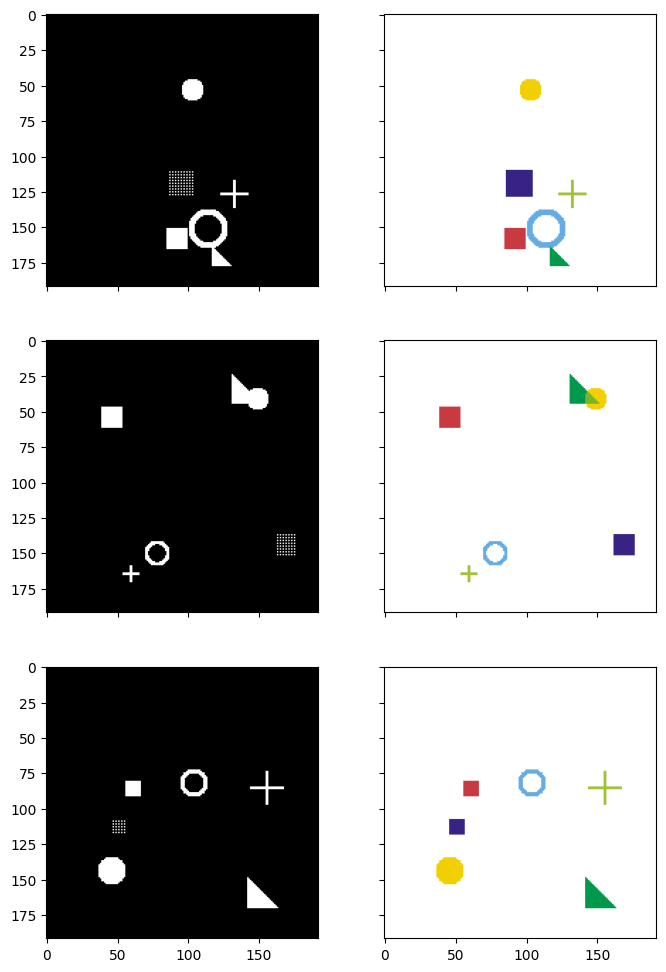

In [11]:
# generate random images
input_images, target_masks = generate_random_data(192, 192, count=3)

# change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

# left: input, right: target
plot_side_by_side([input_images_rgb, target_masks_rgb])

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 50
epochs = 25
learning_rate = 1e-4

In [30]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = generate_random_data(192, 192, count=count)
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]

# use same transform for train/val for this example
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = SimDataset(2000, transform=transform)
test_dataset = SimDataset(200, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [ ]:
model = UNet(6)
model.to(device)

In [34]:
inputs, labels = next(iter(train_loader))
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

In [33]:
from collections import defaultdict
import torch.nn.functional as F

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def calc_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    for batch_idx, (inputs, labels) in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = calc_loss(outputs, labels)

        loss.backward()
        optimizer.step()

    print(f"epoch {epoch+1}: loss {loss.item()}")



ValueError: too many values to unpack (expected 2)